# 0. Imports and Dataset Load

In [25]:
from functools import partial
from pathlib import Path
import pickle

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import trange
import jax_dataloader.core as jdl
import optax

from rebayes.low_rank_filter.lofi import LoFiParams
from demos.showdown.classification import (
    permuted_mnist as core,
    classification_train as benchmark,
    hparam_tune_clf as hpt,
)

In [27]:
data_kwargs = {
    'n_tasks': 10,
    'ntrain_per_task': 600,
    'nval_per_task': 1_000,
    'ntest_per_task': 1_000,
}

dataset = benchmark.load_permuted_mnist_dataset(**data_kwargs, fashion=True)

output_path = Path(Path.cwd(), 'output', 'permuted-mnist', 'toy-experiment')
output_path.mkdir(parents=True, exist_ok=True)

In [4]:
features = [400, 400, 10]
model_dict = benchmark.init_model(type='mlp', features=features)

In [5]:
(Xtr, Ytr), (Xval, Yval), (Xte, Yte) = dataset.values()

In [6]:
# Measure in-task performance after 5 tasks
val_after = 5
X_warmup_tr = Xtr[:val_after*data_kwargs["ntrain_per_task"]]
Y_warmup_tr = Ytr[:val_after*data_kwargs["ntrain_per_task"]]
warmup_train = (X_warmup_tr, Y_warmup_tr)

X_warmup_val = Xval[(val_after-1)*data_kwargs["nval_per_task"]:val_after*data_kwargs["nval_per_task"]]
Y_warmup_val = Yval[(val_after-1)*data_kwargs["nval_per_task"]:val_after*data_kwargs["nval_per_task"]]
warmup_val = (X_warmup_val, Y_warmup_val)

In [7]:
ll_calback = partial(benchmark.eval_callback, evaluate_fn=benchmark.mnist_evaluate_ll)

# 2. FDEKF

## 2.1 Hyperparam Tuning

In [8]:
pbounds={
    'log_init_cov': (-10, 1),
    'log_dynamics_weights': (-50, 0),
    'log_dynamics_cov': (-50, 0),
    'log_alpha': (-50, 0),
}
fdekf_model = 'fdekf'

In [9]:
fdekf_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, warmup_train, warmup_val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'fdekf',
)

In [19]:
%%time
fdekf_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -2.017e+0 | -4.156    | -20.57    | -36.75    | -1.385    |
| 2         | -2.958e+0 | -4.1      | -8.632    | -13.6     | -7.135    |
| 3         | -2.971e+0 | -4.412    | -36.96    | -11.68    | -7.123    |
| 4         | -2.291    | -43.89    | -30.7     | -7.996    | -6.94     |
| 5         | -0.8011   | -46.5     | -18.34    | -20.76    | -3.606    |
| 6         | -1.122    | -16.14    | -15.64    | -28.05    | -6.47     |
| 7         | -2.072    | -21.47    | -26.01    | -6.946    | -0.8171   |
| 8         | -1.984    | -44.71    | -46.98    | -20.16    | -1.284    |
| 9         | -1.003    | -38.68    | -23.24    | -43.2     | -5.905    |
| 10        | -0.9758   | -42.4     | -28.51    | -10.36    | -5.523    |
| 11        | -976.2    | -41.11    | -4.537    | -22.73    | -8.895    |
| 12        | -520.1    | -14.06    | 

## 2.2 Test-Set Evaluation

In [10]:
fdekf_hparams = {
    'initial_covariance': 0.027148086840588965,
    'dynamics_weights': 0.9999999990377035,
    'dynamics_covariance': 1.0791385346291648e-08,
    'dynamics_covariance_inflation_factor': 6.359638985510327e-21
}

In [11]:
# fdekf_hparams = hpt.get_best_params(fdekf_optimizer, method=fdekf_model)
fdekf_estimator, _ = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                         fdekf_hparams, model_dict['emission_mean_function'],
                                         model_dict['emission_cov_function'], 
                                         method=fdekf_model)

In [12]:
accuracy_fn = lambda logits, label: jnp.mean(logits.argmax(axis=-1) == label)
evaluate_accuracy = partial(
    benchmark.evaluate_function,
    loss_fn=accuracy_fn
)

In [13]:
def test_acc_callback(bel, pred_obs, t, x, y, bel_pred, i, **kwargs):
    X_test, y_test, apply_fn = kwargs["X_test"], kwargs["y_test"], kwargs["apply_fn"]
    ntest_per_batch = kwargs["ntest_per_batch"]
    
    prev_test_batch, curr_test_batch = i*ntest_per_batch, (i+1)*ntest_per_batch
    curr_X_test, curr_y_test = X_test[prev_test_batch:curr_test_batch], y_test[prev_test_batch:curr_test_batch]
    cum_X_test, cum_y_test = X_test[:curr_test_batch], y_test[:curr_test_batch]
    
    overall_accuracy = evaluate_accuracy(bel.mean, apply_fn, cum_X_test, cum_y_test)
    current_accuracy = evaluate_accuracy(bel.mean, apply_fn, curr_X_test, curr_y_test)
    task1_accuracy = evaluate_accuracy(bel.mean, apply_fn, X_test[:ntest_per_batch], y_test[:ntest_per_batch])
    result = {
        'overall': overall_accuracy,
        'current': current_accuracy,
        'task1': task1_accuracy,
    }
    return result

In [14]:
def evaluate_model(estimator, n_iter=5, bel=None):
    overall_accs, current_accs, task1_accs = [], [], []
    for i in trange(n_iter):
        # Load dataset with random permutation and random shuffle
        dataset = benchmark.load_permuted_mnist_dataset(**data_kwargs, key=i, fashion=True)
        (Xtr, Ytr), _, (Xte, Yte) = dataset.values()
        train_ds = jdl.ArrayDataset(Xtr, Ytr)
        train_loader = jdl.DataLoaderJax(
            train_ds, batch_size=data_kwargs["ntrain_per_task"], shuffle=False, drop_last=False
        )

        test_kwargs = {
            'X_test': Xte,
            'y_test': Yte,
            'ntest_per_batch': data_kwargs["ntest_per_task"],
            'apply_fn': model_dict["apply_fn"],
        }

        _, accs = estimator.scan_dataloader(
            train_loader, 
            callback=test_acc_callback, 
            bel=bel,
            callback_at_end=False,
            **test_kwargs
        )
        overall_accs.append(jnp.array([res['overall'] for res in accs]))
        current_accs.append(jnp.array([res['current'] for res in accs]))
        task1_accs.append(jnp.array([res['task1'] for res in accs]))
    
    overall_accs, current_accs, task1_accs = jnp.array(overall_accs), jnp.array(current_accs), jnp.array(task1_accs)
    overall_accs, current_accs, task1_accs = \
        overall_accs.reshape((n_iter, -1)), current_accs.reshape((n_iter, -1)), task1_accs.reshape((n_iter, -1))

    result = {
        'overall': overall_accs.mean(axis=0),
        'overall-std': overall_accs.std(axis=0),
        'current': current_accs.mean(axis=0),
        'current-std': current_accs.std(axis=0),
        'task1': task1_accs.mean(axis=0),
        'task1-std': task1_accs.std(axis=0),
    }
    
    return result


In [15]:
fdekf_res = evaluate_model(fdekf_estimator)

100%|██████████| 5/5 [10:24<00:00, 124.83s/it]


In [26]:
filename = f'fdekf_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(fdekf_res, f)

# 3. VDEKF

## 3.1 Hyperparam Tuning

In [16]:
vdekf_model = 'vdekf'

In [17]:
vdekf_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, warmup_train, warmup_val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'vdekf',
)

In [18]:
%%time
vdekf_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -212.2    | -4.156    | -20.57    | -36.75    | -1.385    |
| 2         | -6.491e+0 | -4.1      | -8.632    | -13.6     | -7.135    |
| 3         | -537.5    | -4.412    | -36.96    | -11.68    | -7.123    |
| 4         | -2.291    | -43.89    | -30.7     | -7.996    | -6.94     |
| 5         | -0.8618   | -46.5     | -18.34    | -20.76    | -3.606    |
| 6         | -1.121    | -16.14    | -15.64    | -28.05    | -6.47     |
| 7         | -2.059    | -21.47    | -26.01    | -6.946    | -0.8171   |
| 8         | -1.851    | -44.71    | -46.98    | -20.16    | -1.284    |
| 9         | -0.9915   | -38.68    | -23.24    | -43.2     | -5.905    |
| 10        | -0.9704   | -42.4     | -28.51    | -10.36    | -5.523    |
| 11        | -1.447e+0 | -41.11    | -4.537    | -22.73    | -8.895    |
| 12        | -328.0    | -14.06    | 

## 3.2 Test-Set Evaluation

In [ ]:
# vdekf_hparams = {
# }

In [19]:
vdekf_hparams = hpt.get_best_params(vdekf_optimizer, method=vdekf_model)
vdekf_estimator, _ = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                         vdekf_hparams, model_dict['emission_mean_function'],
                                         model_dict['emission_cov_function'], 
                                         method=vdekf_model)

In [20]:
vdekf_hparams

{'initial_covariance': 0.014917355424284394,
 'dynamics_weights': 1.0,
 'dynamics_covariance': 2.085722038177336e-19,
 'dynamics_covariance_inflation_factor': 4.785838684065285e-08}

In [21]:
vdekf_res = evaluate_model(vdekf_estimator)

100%|██████████| 5/5 [10:43<00:00, 128.68s/it]


In [28]:
filename = f'vdekf_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(vdekf_res, f)

# 4. LoFi (Rank 1)

## 4.1 Hyperparam Tuning

In [29]:
lofi_1_params = LoFiParams(
    memory_size=1,
    diagonal_covariance=False,
)

In [30]:
lofi_1_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, warmup_train, warmup_val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'lofi', lofi_params=lofi_1_params
)

In [31]:
%%time
lofi_1_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------


## 4.2 Test-Set Evaluation

In [ ]:
# lofi_1_hparams = {
# }

In [ ]:
lofi_1_hparams = hpt.get_best_params(lofi_1_optimizer, method='lofi')
lofi_1_estimator, _ = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                          lofi_1_hparams, model_dict['emission_mean_function'],
                                          model_dict['emission_cov_function'], 
                                          method='lofi', lofi_params=lofi_1_params)

In [ ]:
lofi_1_hparams

In [ ]:
lofi_1_res = evaluate_model(lofi_1_estimator)

# 5. LoFi (Rank 5)

## 5.1 Hyperparam Tuning

In [ ]:
lofi_5_params = LoFiParams(
    memory_size=5,
    diagonal_covariance=False,
)

In [ ]:
lofi_5_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, warmup_train, warmup_val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'lofi', lofi_params=lofi_5_params
)

In [ ]:
%%time
lofi_5_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

## 5.2 Test-Set Evaluation

In [ ]:
# lofi_5_hparams = {
# }

In [ ]:
lofi_5_hparams = hpt.get_best_params(lofi_5_optimizer, method='lofi')
lofi_5_estimator, _ = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                          lofi_5_hparams, model_dict['emission_mean_function'],
                                          model_dict['emission_cov_function'], 
                                          method='lofi', lofi_params=lofi_5_params)

In [ ]:
lofi_5_hparams

In [ ]:
lofi_5_res = evaluate_model(lofi_5_estimator)

# 6. Lofi (Rank 20)

## 6.1 Hyperparam Tuning

In [ ]:
lofi_20_params = LoFiParams(
    memory_size=20,
    diagonal_covariance=False,
)

In [ ]:
lofi_20_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, warmup_train, warmup_val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'lofi', lofi_params=lofi_20_params
)

In [ ]:
%%time
lofi_20_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

## 6.2 Test-Set Evaluation

In [ ]:
# lofi_20_hparams = {
# }

In [ ]:
lofi_20_hparams = hpt.get_best_params(lofi_20_optimizer, method='lofi')
lofi_20_estimator, _ = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                           lofi_20_hparams, model_dict['emission_mean_function'],
                                           model_dict['emission_cov_function'], 
                                           method='lofi', lofi_params=lofi_20_params)

In [ ]:
lofi_20_hparams

In [ ]:
lofi_20_res = evaluate_model(lofi_20_estimator)

# 7. Online Gradient Descent

## 7.1 Hyperparam Tuning

In [ ]:
rsgd_pbounds = {
    'log_lr': (-8.0, 0.0),
}

In [ ]:
ogd_params = {
    'loss_fn': optax.softmax_cross_entropy,
    'buffer_size': 1,
    'dim_output': 10
}

In [ ]:
ogd_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, warmup_train, warmup_val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'sgd', **ogd_params
)

In [ ]:
%%time
ogd_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

## 7.2 Test-Set Evaluation

In [ ]:
# ogd_hparams = {
# }

In [ ]:
ogd_hparams = hpt.get_best_params(ogd_optimizer, method='sgd')
ogd_estimator, _ = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                       ogd_hparams, model_dict['emission_mean_function'],
                                       model_dict['emission_cov_function'], 
                                       method='sgd', **ogd_params)

In [ ]:
ogd_hparams

In [ ]:
ogd_res = evaluate_model(ogd_estimator)

# 8. SGD-RB (Rank 20)

## 8.1 Hyperparam Tuning

In [ ]:
sgd_rb_params = {
    'loss_fn': optax.softmax_cross_entropy,
    'buffer_size': 20,
    'dim_output': 10
}

In [ ]:
sgd_rb_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, warmup_train, warmup_val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'sgd', **sgd_rb_params
)

In [ ]:
%%time
sgd_rb_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

## 8.2 Test-Set Evaluation

In [ ]:
# sgd_rb_hparams = {
# }

In [ ]:
sgd_rb_hparams = hpt.get_best_params(sgd_rb_optimizer, method='sgd')
sgd_rb_estimator, _ = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                       ogd_hparams, model_dict['emission_mean_function'],
                                       model_dict['emission_cov_function'], 
                                       method='sgd', **sgd_rb_params)

In [ ]:
sgd_rb_hparams

In [ ]:
sgd_rb_res = evaluate_model(sgd_rb_estimator)

# 9. Model Comparison

In [42]:
results = {
    # 'sgd-online': online_sgd_result,
    # 'sgd-rb': rsgd_result,
    'fdekf': fdekf_res,
    # 'vdekf': vdekf_res,
    # 'lofi-1': lofi_1_res,
    # 'lofi-5': lofi_5_res,
    # 'lofi-50': lofi_50_res,
}

In [43]:
boundaries = [i for i in range(600, (600*10)+1, 600)]

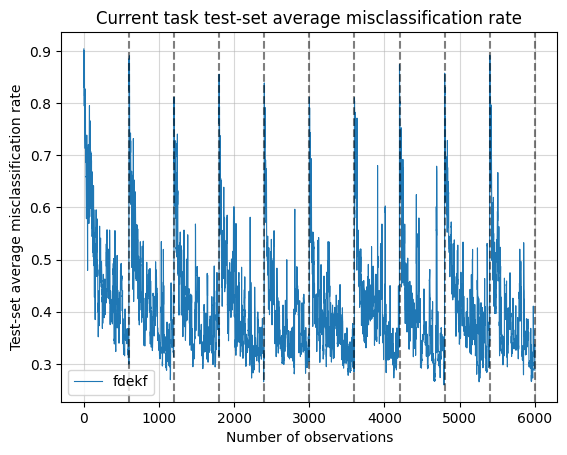

In [49]:
fig, ax = plt.subplots()
for key, val in results.items():
    ax.plot(1.0 - val['current'], label=key, linewidth=0.8)
    ax.fill_between(
        jnp.arange(val['current'].shape[0]),
        1.0 - val['current'] - val['current-std'],
        1.0 - val['current'] + val['current-std'],
        alpha=0.3
    )
# Task boundaries
for b in boundaries:
    ax.axvline(x=b, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Number of observations')
ax.set_ylabel('Test-set average misclassification rate');
ax.set_title(f'Current task test-set average misclassification rate')
ax.grid(alpha=0.5)
ax.legend();

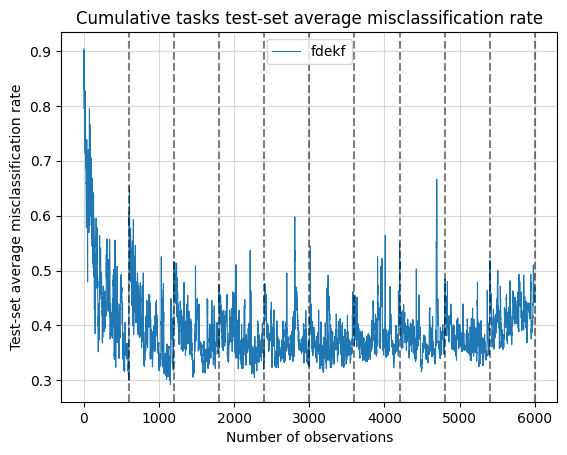

In [50]:
fig, ax = plt.subplots()
for key, val in results.items():
    ax.plot(1.0 - val['overall'], label=key, linewidth=0.8)
    ax.fill_between(
        jnp.arange(val['overall'].shape[0]),
        1.0 - val['overall'] - val['overall-std'],
        1.0 - val['overall'] + val['overall-std'],
        alpha=0.3
    )
# Task boundaries
for b in boundaries:
    ax.axvline(x=b, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Number of observations')
ax.set_ylabel('Test-set average misclassification rate');
ax.set_title(f'Cumulative tasks test-set average misclassification rate')
ax.grid(alpha=0.5)
ax.legend();
# fig.savefig(f'{output_path}_{name}.pdf', bbox_inches='tight')

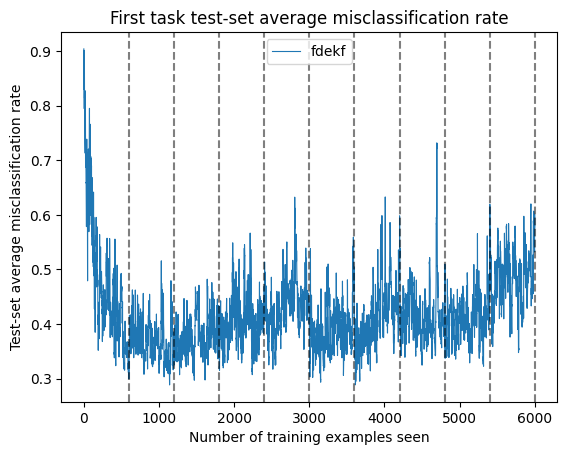

In [51]:
fig, ax = plt.subplots()
for key, val in results.items():
    ax.plot(1.0 - val['task1'], label=key, linewidth=0.8)
    ax.fill_between(
        jnp.arange(val['task1'].shape[0]),
        1.0 - val['task1'] - val['task1-std'],
        1.0 - val['task1'] + val['task1-std'],
        alpha=0.3
    )
# Task boundaries
for b in boundaries:
    ax.axvline(x=b, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate');
ax.set_title(f'First task test-set average misclassification rate')
ax.legend();